# Stock Clustering

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
data_dir = "data"
file_path = os.path.join(data_dir, "feature_engineering_data.csv")
stock_data = pd.read_csv(file_path)

In [4]:
stock_data.columns

Index(['symbol', 'avg_adj_close', 'avg_daily_return', 'avg_volume',
       'volume_volatility', 'volatility', 'cumulative_return',
       'avg_intraday_range', 'beta_proxy', 'max_drawdown', 'market_cap'],
      dtype='object')

In [5]:
cluster_features = stock_data[
    [
        "avg_adj_close",
        "avg_daily_return",
        "avg_volume",
        "volume_volatility",
        "volatility",
        "cumulative_return",
        "avg_intraday_range",
        "beta_proxy",
        "max_drawdown",
    ]
]

In [6]:
print(cluster_features.isnull().sum())

avg_adj_close         0
avg_daily_return      0
avg_volume            0
volume_volatility     0
volatility            0
cumulative_return     0
avg_intraday_range    0
beta_proxy            0
max_drawdown          0
dtype: int64


In [7]:
print(np.isinf(cluster_features).sum())

avg_adj_close         0
avg_daily_return      0
avg_volume            0
volume_volatility     0
volatility            0
cumulative_return     0
avg_intraday_range    0
beta_proxy            0
max_drawdown          0
dtype: int64


In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

In [9]:
scaled_df = pd.DataFrame(scaled_features, columns=cluster_features.columns)
scaled_df.sample(10)

,avg_adj_close,avg_daily_return,avg_volume,volume_volatility,volatility,cumulative_return,avg_intraday_range,beta_proxy,max_drawdown
61,0.836941,-0.200691,-0.186884,-0.267902,0.249755,-0.363628,0.722488,1.606954,0.457676
132,-0.373182,-0.180485,-0.312759,-0.369459,-0.368091,-0.114893,-0.426783,-1.426111,0.778100
111,-0.224869,0.203837,-0.310245,-0.362402,-0.197905,0.354328,-0.153403,0.007228,0.254186
29,-0.305778,0.345138,0.278232,0.403865,-0.266965,0.216698,-0.124046,0.723922,-0.798258
245,-0.318626,0.222382,-0.128597,-0.196816,-0.306773,0.402095,-0.397364,0.206282,0.722174
228,-0.344862,-1.054448,0.219882,0.258922,-0.245881,-1.517568,-0.319861,-0.777617,-1.935153
37,0.136536,0.117479,0.344150,0.719137,0.152853,0.154811,0.318368,-1.176791,0.583615
15,-0.047888,0.075268,-0.263875,-0.264414,-0.133463,0.151512,-0.226624,-0.392099,0.997778
139,-0.374409,-0.019947,-0.313088,-0.370650,-0.364939,-0.058958,-0.415022,0.010575,0.123936
247,-0.340110,0.423331,-0.291333,-0.298047,-0.235665,0.085047,-0.288456,0.374300,-1.568783


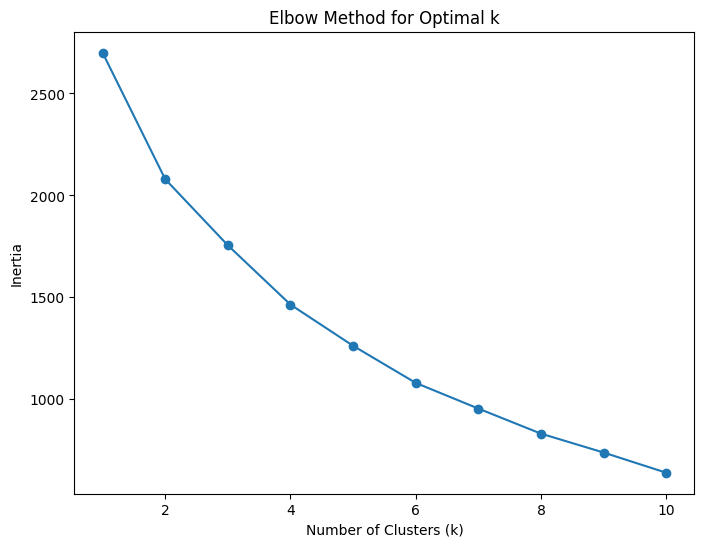

In [10]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [11]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
stock_data["cluster"] = kmeans.fit_predict(scaled_features)

In [12]:
print("Clustered Features Sample:")
stock_data[["symbol", "market_cap", "cluster"]].sample(10)

Clustered Features Sample:


,symbol,market_cap,cluster
98,FLYX,Micro-Cap,1
143,JRSH,Nano-Cap,1
45,BKNG,Large-Cap,2
150,LEU,Small-Cap,0
267,TSLA,Mega-Cap,3
63,CENX,Small-Cap,1
238,SFST,Micro-Cap,0
74,CRNT,Micro-Cap,0
278,UNH,Mega-Cap,0
192,OPRA,Small-Cap,0


In [13]:
cluster_summary = (
    stock_data.groupby("cluster")
    .agg(
        {
            "avg_adj_close": "mean",
            "volatility": "mean",
            "avg_daily_return": "mean",
            "cumulative_return": "mean",
            "avg_volume": "mean",
            "volume_volatility": "mean",
            "avg_intraday_range": "mean",
            "beta_proxy": "mean",
            "max_drawdown": "mean",
            "symbol": "count",
            # "market_cap": lambda x: x.mode()[0],
        }
    )
    .rename(columns={"symbol": "symbol_count"})
)
market_cap_counts = pd.crosstab(stock_data["cluster"], stock_data["market_cap"]).reset_index()
cluster_summary = cluster_summary.merge(market_cap_counts, on="cluster", how="left")
print("Cluster Summary:")
cluster_summary

Cluster Summary:


,cluster,avg_adj_close,volatility,avg_daily_return,cumulative_return,avg_volume,volume_volatility,avg_intraday_range,beta_proxy,max_drawdown,symbol_count,Large-Cap,Mega-Cap,Micro-Cap,Mid-Cap,Nano-Cap,Small-Cap
0,0,205.379208,14.387123,0.001519,0.162611,4.621637e+06,2.249014e+06,4.786935,0.396970,-0.164212,120,28,33,13,25,2,19
1,1,42.678343,3.282402,0.002571,0.215481,3.664074e+06,1.985125e+06,0.992313,0.152570,-0.194584,127,21,13,26,23,23,21
2,2,4767.235800,355.703329,0.002271,0.233250,2.269054e+05,9.116594e+04,92.501000,0.263691,-0.128507,1,1,0,0,0,0,0
3,3,91.441883,17.837825,0.003450,0.274875,9.103887e+07,4.794971e+07,4.165550,0.329422,-0.426699,6,0,3,0,2,1,0
4,4,11.944340,2.256499,-0.003896,-0.317455,1.486597e+06,1.453360e+06,0.628424,0.212043,-0.529452,46,0,1,11,0,24,10


In [14]:
save_to_path = os.path.join(data_dir, "cluster_summary_with_{optimal_k}_clusters.csv")
cluster_summary.to_csv(save_to_path, index=False)

---